# 应用ECMWF的magics来进行天气分析

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import xarray as xr
from Magics import macro as magics
from nmc_met_io.retrieve_micaps_server import get_model_grid
import pkg_resources

In [3]:
shpfile = pkg_resources.resource_filename('nmc_met_graphics', "resources/maps/bou2_4p")

In [4]:
shpfile

'/media/kan-dai/work01/DK_WORK_CODE/repository/nmc_met_graphics/nmc_met_graphics/resources/maps/bou2_4p'

## 850hPa温度场分析

In [5]:
# 读入数据
data = get_model_grid("ECMWF_HR/TMP/850", varattrs={'units':'degree', 'long_name':'temperature'})

In [7]:
data

<xarray.Dataset>
Dimensions:                  (lat: 281, level: 1, lon: 361, time: 1)
Coordinates:
  * time                     (time) datetime64[ns] 2019-11-20T08:00:00
  * level                    (level) float32 850.0
  * lat                      (lat) float64 60.0 59.75 59.5 ... -9.5 -9.75 -10.0
  * lon                      (lon) float64 60.0 60.25 60.5 ... 149.5 149.8 150.0
    forecast_reference_time  datetime64[ns] 2019-11-19T08:00:00
    forecast_period          (time) float64 24.0
Data variables:
    data                     (time, level, lat, lon) float32 -13.354549 ... 18.004826
Attributes:
    Conventions:  CF-1.6
    Origin:       MICAPS Cassandra Server

In [6]:
type(data.coords)

xarray.core.coordinates.DatasetCoordinates

In [7]:
type(data.data_vars)

xarray.core.dataset.DataVariables

In [8]:
[data.coords, data.data_vars][1]

Data variables:
    data     (time, level, lat, lon) float32 9.766758 9.688633 ... 16.71207

In [9]:
data.keys

<bound method Mapping.keys of <xarray.Dataset>
Dimensions:                  (lat: 281, level: 1, lon: 361, time: 1)
Coordinates:
  * time                     (time) datetime64[ns] 2019-08-15T08:00:00
  * level                    (level) float32 850.0
  * lat                      (lat) float64 60.0 59.75 59.5 ... -9.5 -9.75 -10.0
  * lon                      (lon) float64 60.0 60.25 60.5 ... 149.5 149.8 150.0
    forecast_reference_time  datetime64[ns] 2019-08-14T08:00:00
    forecast_period          (time) float64 24.0
Data variables:
    data                     (time, level, lat, lon) float32 9.766758 ... 16.71207
Attributes:
    Conventions:  CF-1.6
    Origin:       MICAPS Cassandra Server>

In [10]:
for ds_attributes in [data.coords, data.data_vars]:
    print(ds_attributes)

Coordinates:
  * time                     (time) datetime64[ns] 2019-08-12T08:00:00
  * level                    (level) float32 850.0
  * lat                      (lat) float64 60.0 59.75 59.5 ... -9.5 -9.75 -10.0
  * lon                      (lon) float64 60.0 60.25 60.5 ... 149.5 149.8 150.0
    forecast_reference_time  datetime64[ns] 2019-08-11T08:00:00
    forecast_period          (time) float64 24.0
Data variables:
    data     (time, level, lat, lon) float32 13.10294 13.735752 ... 17.024815


In [25]:
lat_dim_names = sorted(data['lat'].dims)
n_lat_dims = len(lat_dim_names)
n_lat_dims

1

In [26]:
def _mxarray_flatten(xarray_dataset, dims_to_flatten, dims_to_ignore):
    # flatten an nD matrix into a 2d matrix by slicing the matrix based on the values given to
    # dimensions in dims_to_flatten.
    for dim in xarray_dataset.dims:
        if dim in dims_to_ignore:
            continue
        elif dim in dims_to_flatten:
            if dims_to_flatten[dim] not in xarray_dataset[dim]:
                raise ValueError("Dimension not valid. dimension={} dtype={} options={} dtype={}"
                        .format(dim, type(dim), xarray_dataset[dim].values,
                            xarray_dataset[dim].dtype))
            else:
                xarray_dataset = xarray_dataset.loc[{dim: dims_to_flatten[dim]}]
        elif xarray_dataset[dim].size == 1:
            # automatically squash this dimension
            d = xarray_dataset[dim].values[0]
            print("automatically squashing dimension: {}={}".format(dim, d))
            xarray_dataset = xarray_dataset.loc[{dim: d}]
        else:
            raise ValueError("Missing dimension to flatten. "
                    "Please pick a dimension from which to slice data. "
                    "dimension={} options={} dtype={}"
                    .format(dim, xarray_dataset[dim].values, xarray_dataset[dim].dtype))
    return xarray_dataset

In [29]:
for dim in data.dims:
    if dim in ['lat','lon']:
        continue
    else:
        d = data[dim].values[0]
        data = data.loc[{dim: d}]

In [ ]:
data

In [10]:
lat = data['lat'].values.astype(np.float64)
lon = data['lon'].values.astype(np.float64)
d = data['data']['time'].values[0]
xarray_dataset = data['data'].loc[{'time': d}]
input_field_values = np.squeeze(xarray_dataset.values.astype(np.float64))

In [15]:
input_field_values.shape

(281, 361)

In [16]:
lat.shape

(281,)

In [8]:
data = magics.minput(
            input_field           = input_field_values,
            input_latitudes_list  = lat,
            input_longitudes_list = lon,
            input_metadata        = dict(data['data'].attrs) )

In [9]:
# setting of the geographical data
area = magics.mmap(subpage_map_projection="cylindrical",
                   subpage_lower_left_longitude=70.,
                   subpage_lower_left_latitude=15.,
                   subpage_upper_right_longitude=128.,
                   subpage_upper_right_latitude=56.,)

In [10]:
coast = magics.mcoast(map_coastline_land_shade = "off",
      map_coastline_land_shade_colour = "cream",
      map_user_layer = "on",
      map_user_layer_name = shpfile,
      map_user_layer_colour = "navy",
      map_grid_line_style = "dash",
      map_grid_colour = "grey",
      map_label = "on",
      map_label_height=0.5,
      map_cities = "on",
      map_coastline_colour = "grey")

In [11]:
contour = magics.mcont(contour_highlight_colour= "black",
                contour_highlight_thickness= 4,
                contour_hilo= "off",
                contour_interval= 4.,
                contour_label= "on",
                contour_label_frequency= 2,
                contour_label_height= 0.4,
                contour_level_selection_type= "interval",
                contour_line_colour= "black",
                contour_line_thickness= 2,
                legend='off',
                contour_legend_text= "850hPa Temperature",
            )

In [16]:
t_cont = magics.mcont(
    legend                            = "on",
    contour                           = "off",
    contour_level_selection_type      = "level_list",
    contour_level_list                = [-30.,-20.,0.,20.,30.,35],
    contour_gradients_step_list       = [5, 10 ,10 ,5],
    contour_label                     = "off",
    contour_shade                     = "on",
    contour_shade_colour_method       = "gradients",
    contour_gradients_technique       = "rgb",
    contour_shade_method              = "area_fill",
    contour_gradients_colour_list     = ["RGB(0.01961,0.251,0.4157)","greenish_blue","white",
                                         "orangish_red","RGB(0.3756,0.06648,0.05582)"],
    contour_gradients_waypoint_method = "ignore")

# Defining legend for temperature
temp_legend = magics.mlegend (    
    legend_display_type       = "continuous",
    legend_automatic_position = "right",
    legend_title              = "on",
    legend_title_text         = "Temperature at 850 hPa",
    legend_text_font_size     = "0.45",
    legend_text_colour        = "#2b619e",
    legend_text_composition    = "user_text_only",
    legend_values_list         = [-30.,-20.,-10.,0.,10.,20.,30.])

In [17]:
profile_left = magics.page(
    layout='positional',
    page_frame='off', 
    page_id_line='off')

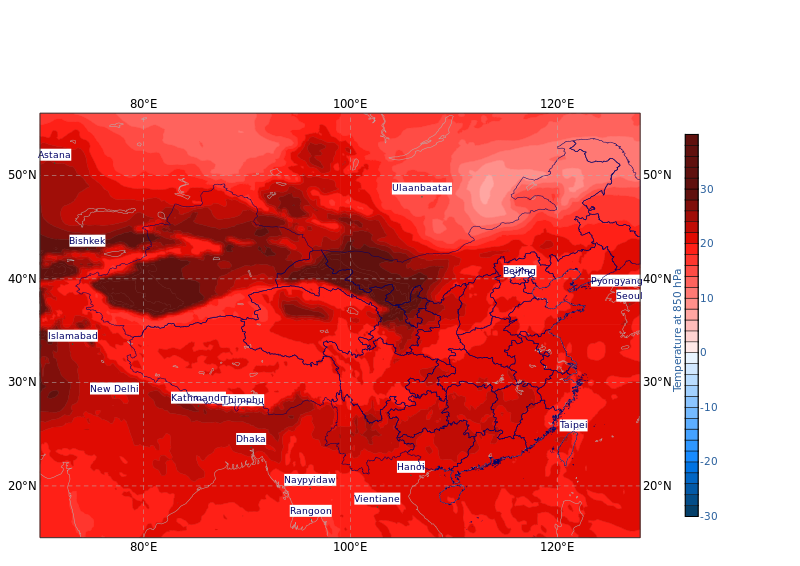

In [18]:
magics.plot(profile_left,area, data, t_cont,coast,temp_legend)